In [7]:
from script import df_mobpro_brut, arr_marseille, arr_paris, arr_lyon, contours_comm

In [2]:
df_mobpro_brut

,Unnamed: 0,COMMUNE,ARM,DCFLT,DCLT,AGEREVQ,CS1,DEROU,DIPL,EMPL,...,REGION,REGLT,SEXE,STAT,STOCD,TP,TRANS,TYPL,TYPMR,VOIT
0,0,01001,ZZZZZ,99999,01001,40,2,Z,16,21,...,84,84,2,21,21,1,1,1,41,2
1,1,01001,ZZZZZ,99999,01001,45,5,Z,14,16,...,84,84,2,10,22,2,5,2,12,1
2,2,01001,ZZZZZ,99999,01001,20,2,Z,14,21,...,84,84,2,21,10,1,1,1,41,3
3,3,01001,ZZZZZ,99999,01001,55,2,Z,3,21,...,84,84,2,21,10,1,1,1,41,1
4,4,01001,ZZZZZ,99999,01001,55,2,Z,13,22,...,84,84,1,22,10,1,5,1,41,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8079957,8079957,97424,ZZZZZ,99999,97424,40,5,0,14,15,...,4,04,2,10,10,1,5,1,12,1
8079958,8079958,97424,ZZZZZ,99999,97424,45,5,0,13,15,...,4,04,2,10,10,2,2,1,32,0
8079959,8079959,97424,ZZZZZ,99999,97424,50,3,1,13,16,...,4,04,1,10,10,1,4,1,42,1
8079960,8079960,97424,ZZZZZ,99999,97424,55,6,0,14,16,...,4,04,1,10,10,2,4,1,11,0


TRANS
5    5345431
6    1501858
2     537717
1     301139
3     234421
4     159396
Name: count, dtype: int64


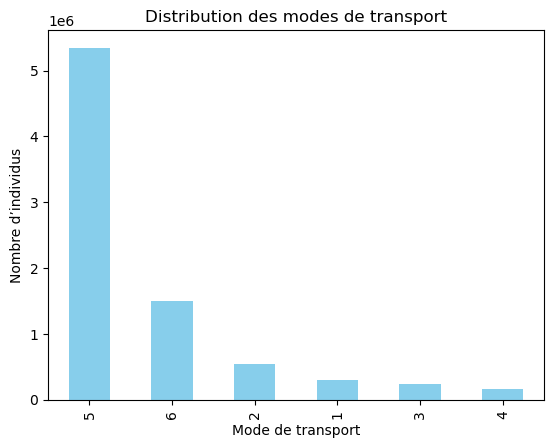

In [3]:
# Distribution des modes de transport utilisés pour aller travailler
transport_distribution = df_mobpro_brut['TRANS'].value_counts()
print(transport_distribution)

# Visualisation
import matplotlib.pyplot as plt
transport_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution des modes de transport')
plt.xlabel('Mode de transport')
plt.ylabel('Nombre d’individus')
plt.show()


TRANS
1    44.077751
2    38.992081
3    38.212106
4    38.061997
5    39.720284
6    37.170818
Name: AGEREVQ, dtype: float64


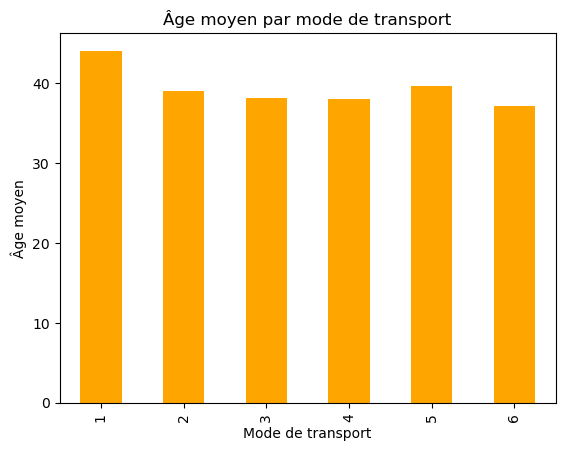

In [5]:
# Âge moyen par mode de transport
age_transport = df_mobpro_brut.groupby('TRANS')['AGEREVQ'].mean()
print(age_transport)

# Visualisation
age_transport.plot(kind='bar', color='orange')
plt.title('Âge moyen par mode de transport')
plt.xlabel('Mode de transport')
plt.ylabel('Âge moyen')
plt.show()


In [6]:
# Distribution des modes de transport par catégorie socio-professionnelle
cs1_transport = pd.crosstab(df_mobpro_brut['CS1'], df_mobpro_brut['TRANS'])
print(cs1_transport)

# Heatmap
import seaborn as sns
sns.heatmap(cs1_transport, annot=True, fmt='d', cmap='Blues')
plt.title('Modes de transport par catégorie socio-professionnelle')
plt.xlabel('Mode de transport')
plt.ylabel('Catégorie socio-professionnelle')
plt.show()


NameError: name 'pd' is not defined